# Defect Analysis with issues trackers and pandas

Defect Analysis is a classic analysis technique to get insights into how buggy your system might be. One variant of Defect Analysis is to use an issue tracker (i.e., the system where you manage your issues) to compare the found and fixed bugs over time. With this analysis, you can find out if you
- have a spike in bug reports (where you should investigate deeper to identify the primary sources of the bugs)
- are doing well fixing bugs (and therefore can be confident to release a stable version of your software)
- are keeping bugs at bay (and allow the implementation of new features in a more risk-free environment)

In this blog post / notebook, I'll demonstrate a Defect Analysis technique using the issues tracker YouTrack and standard tools like Python, requests, json, pandas, and matplotlib. We want to analyze the relatively new software product "Code With Me" from Jetbrians (a plugin that enables you to share your locally running project from your IDE with anyone). The issues from "Code With Me" are managed in YouTrack, hosted by Jetbrains, and open to everyone. This allows us to use this issues tracker as our playground.

The second goal of this article is to write as less confusing analysis code as possible. I want to achieve this by using the tools mentioned above to get a readable analysis of the defects in a software system.

This said, be aware that your issue tracker might bring Defect Analysis to you out of the box (YouTrack does this AFAIK). Click through the reporting features of your system before you reinvent the wheel! Nevertheless, I'll show you how you can do it on your own. There might be similar use cases to track the progress of work. In these cases, you can reuse many steps from this analysis.

## How to get the data
First, we have to retrieve the data we need from the issue tracker system. We can do this in various ways (direct database access, scraping the website, or using an API provided by the system). How it works depends on your tool. 

In our case, we're using YouTrack's REST API to download some data. To do this, we create an URL to get the data we need. I've dug deep into the YouTrack REST API documentation and found the information I needed to export only bugs, including so-called "project custom fields." These are additional information that is specific to the software project.

Note that we set an upper limit of the  latest 1000 bug entries to not overload the available public issue tracker system.

In [1]:
RESOURCE = "https://youtrack.jetbrains.com/api/issues"
TOP = 1000
PROJECT = "{Code With Me}"
FIELDS = "created,resolved,fields(projectCustomField(field(name)),value(name))"
QUERY = f"Type: Bug Project: {PROJECT} order by: created"

URL = f"{RESOURCE}?$top={TOP}&fields={FIELDS}&query={QUERY}"
URL

'https://youtrack.jetbrains.com/api/issues?$top=1000&fields=created,resolved,fields(projectCustomField(field(name)),value(name))&query=Type: Bug Project: {Code With Me} order by: created'

Using `requests`, we can send a request to the YouTrack issue tracker and get back a response with the bugs we've queried.

In [2]:
import requests
response = requests.get(URL)
# show only 100 chars to get an idea of the returned data
response.text[:100]

'[{"resolved":null,"created":1612279498090,"fields":[{"projectCustomField":{"field":{"name":"Type","$'

Of course, you could just read in the response text directly with the `read_json` method of pandas. This would put all the standard fields into columns.

In [3]:
import pandas as pd
df = pd.read_json(response.text)
df.head(1)

,resolved,created,fields,$type
0,NaN,1612279498090,[{'projectCustomField': {'field': {'name': 'Ty...,Issue


With this DataFrame, we could dig into a simple and create some first summarizations upon that. No problem. But we want to do an advanced Defect Analysis as well that uses the custom fields. The custom fields are project-specific, i.e., they are returned in a different way as the standard fields. One custom field contains information about the "Subsystems" (= components) of the project. This is a nice additional information to get some insights into how different components of the software systems are how buggy.

We have to treat these custom fields differently. `json_normalize` allows us to do this. Technically, there is a nested JSON structure in the response data. We need to flatten this data structure. For this, we are telling `json_normalize` to dig deeper into the nested data structure. So deep until we are at the position or data that we want to use.

I don't go into details about how `json_normalize` works. With `record_path`, we are saying which nested JSON data structure we want to entangle (in our case: `fields`). With `meta`, we are specifying which data from the outer data structure should be duplicated for each row that's occurring in the nested data structure.

As a result, we've flattened the JSON data structure into a nice looking DataFrame called `raw`.

In [4]:
import json
raw = pd.json_normalize(
        json.loads(response.text),
        record_path="fields",
        meta = ['created', 'resolved'])
raw.head(1).T

,0
$type,SingleEnumIssueCustomField
projectCustomField.field.name,Type
projectCustomField.field.$type,CustomField
projectCustomField.$type,EnumProjectCustomField
value.name,Bug
value.$type,EnumBundleElement
value,NaN
created,1612279498090
resolved,None


Next, we are filtering out some data we don't need. We are interested in the values of the `Subsystem` data for our advanced analysis later on. We can filter this data with pandas. We also just want to keep the data that we really need:
- the column `created`: the time a bug was created
- the column `resolved`: the time where a bugfix was confirmed
- the column `value.name`: the name of the subsystem

We also rename the `value.name` columns to `subsystem` to improve the understandability of our new `defects` DataFrame.

In [5]:
defects = raw[raw['projectCustomField.field.name'] == "Subsystem"][['created', 'resolved', 'value.name']].copy()
defects = defects.rename(columns={"value.name": "subsystem"})
defects.head(1)

,created,resolved,subsystem
2,1612279498090,None,Am uncertain I


OK, we're now ready for the Defect Analysis part!

## Simple Subsystem Defect Analysis

Let's first take a look at the defect distribution over the subsystems. With `value_counts()`, we can summarize the entries along with their subsystems.

In [6]:
defects_per_subsystem = defects['subsystem'].value_counts()
defects_per_subsystem

Am uncertain I                 106
Connection                      82
Editor and Caret                62
UI                              51
Debugger                        39
Settings                        29
Tests                           28
FollowMe and FullSync           27
Lobby Server                    20
Telephony                       19
Code: Completion                16
Terminal                        16
Code: Navigation and Search     13
Build                           13
Actions                         10
Documentation                    7
Projects View                    5
VCS                              5
Security                         5
Code: Refactoring                5
Code: Intention Actions          4
Code: Highlighting               3
Compatibility with plugins       3
Code: Generation                 3
Code: Find Usages                2
Name: subsystem, dtype: int64

Let's plot the bugs per subsystems.

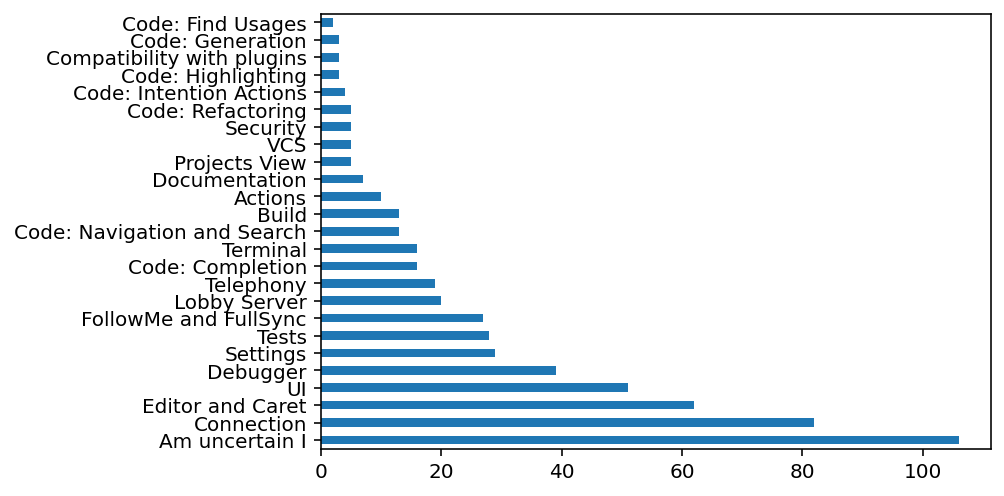

In [7]:
defects_per_subsystem.plot.barh();

We can see where bugs in the "Code With Me" plugin are mainly occurring:
- Connection
- Editor and Caret
- UI

There are also many bugs where it is not clear to which subsystem they belong ("Am uncertain I").

## Defect Trend Analysis
Alright, let's take a look at the development of the reported and fixed bugs. One important question we would like to answer is whether we are getting behind with bug fixing. For this, we are calculating the creation and resolution of bugs over time. That means for us that we have first to convert the corresponding data in the columns `created` and `resolved` into a data format we can calculate time with.

In [8]:
defects['created'] = pd.to_datetime(defects['created'], unit='ms')
defects['resolved'] = pd.to_datetime(defects['resolved'], unit='ms')
defects.head(1)

,created,resolved,subsystem
2,2021-02-02 15:24:58.090,NaT,Am uncertain I


Next, we need a model that shows us the progress of the created and fixed bugs over time. In our case, we create one single `timestamp` column. For each bug, we take the timestamp when a bug was resolved as the entry. For all bugs that are still open, we take the `created` time.

In [9]:
defects['timestamp'] = defects['resolved']
defects['timestamp'] = defects['timestamp'].fillna(defects['created'])
defects.head(1)

,created,resolved,subsystem,timestamp
2,2021-02-02 15:24:58.090,NaT,Am uncertain I,2021-02-02 15:24:58.090


Here comes the interesting part. We now create two new columns in our `defects` DataFrame. 

The first column, called `fixed`, marks all bug entries that were fixed with a `1`. These are bug entries that have an entry with a timestamp in the `resolved` column.

The second column, called `open`, is the opposit of the first one. It contains a `1` for all bugs that weren't resolved yet (= are still open).

This gives us a side by side comparison between resolved and open bug entries.

In [10]:
defects['fixed'] = 0
defects.loc[~defects['resolved'].isnull(), 'fixed'] = 1
defects['open'] = 0
defects.loc[defects['resolved'].isnull(), 'open'] = 1
defects.head(1)

,created,resolved,subsystem,timestamp,fixed,open
2,2021-02-02 15:24:58.090,NaT,Am uncertain I,2021-02-02 15:24:58.090,0,1


Next, we get sort the entries in the DataFrame by the `timestamp` data. This gives us a continuous ordering of the bug entry and fixing events. We're also changing the index to a date-based index to track the bug management's progress over time. We get rid of all the data we don't need anymore, too, keeping only the entries for the fixed and still opened bugs.

In [11]:
timed = defects\
    .sort_values(by='timestamp')\
    .set_index('timestamp')[['fixed', 'open']]
timed.head(1)

,fixed,open
timestamp,,
2020-08-04 15:45:22.220,0,1


Next, we want to create a trend of the opened and fixed bugs. In other words, we need to track the accumulated number of open and fixed bugs for each of our timed entries. We can do this by using the `cumsum()` method on our DataFrame.

In [12]:
cumulated_defects_over_time = timed.cumsum()
cumulated_defects_over_time.head()

,fixed,open
timestamp,,
2020-08-04 15:45:22.220,0,1
2020-08-27 12:17:03.483,1,1
2020-08-28 10:01:42.238,2,1
2020-08-28 10:26:09.818,3,1
2020-08-28 10:55:10.591,3,2


Last, we visualize this DataFrame to get a feeling about how we good (or bad) we are in managing our bugs.

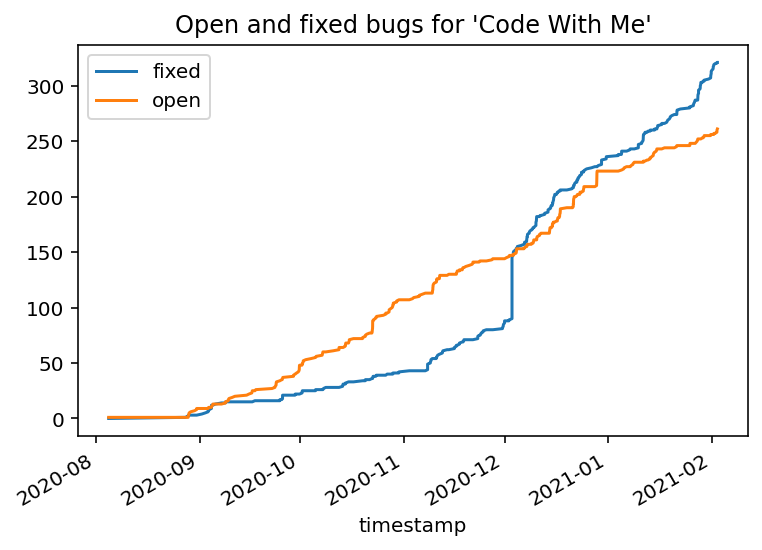

In [13]:
cumulated_defects_over_time.plot(
    title="Open and fixed bugs for 'Code With Me'");

From this visualization, we can see that the team is really aggressive regarding fixing bugs. At the beginning of December 2020, there was a steep increase for bugfixing. It looks like someone clean up the issues tracker right before the official release, doesn't it? :-)

## Conclusion
This blog post shows guided you through a defect analysis using the issues tracker system YouTrack. It gives you some hints on how you could approach analyzing your own issues tracker system. I hope you could also see that this kind of analysis isn't magic. Using appropriate standard tools like pandas help you getting answers to your specific questions in an easy way.